# Descriptive Analysis

### Loading necessary libraries

In [1]:
import pandas as pd 
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import logging
logging.basicConfig(
    level= logging.INFO,
    format= "%(asctime)s - %(levelname)s - %(message)s"
)

### Loading the clean data from parquet files

In [2]:
anki: pd.DataFrame = pd.read_parquet("../data/clean_anki.parquet")
flowmodoro: pd.DataFrame = pd.read_parquet("../data/clean_flowmodoro.parquet")
bir: pd.DataFrame = pd.read_parquet("../data/clean_bir.parquet")
logging.info("Loadded parquet files into dataframes")

2025-11-21 17:23:48,428 - INFO - Loadded parquet files into dataframes


## Parameters

### Total time

In [3]:
total_mins_bir: float = bir.sum().sum()
total_hours_bir: float = round(total_mins_bir / 60, 2)
print(f"Total time spent studying for bir = {total_hours_bir}")

Total time spent studying for bir = 774.4


### Time spent by activity

In [4]:
total_by_act: pd.DataFrame = round(bir.sum() / 60, 1).reset_index()
total_by_act["activity"] = total_by_act["activity"].map({
    "01_own": "Anki",
    "active_recall": "Active Recall",
    "admin": "Admin",
    "anki_craft": "Anki Craft",
    "bhs": "BHS sys",
    "lectures": "Lectures",
    "exam_anki": "Exam Qs"
})
total_by_act = total_by_act.rename(columns={0: "time"})

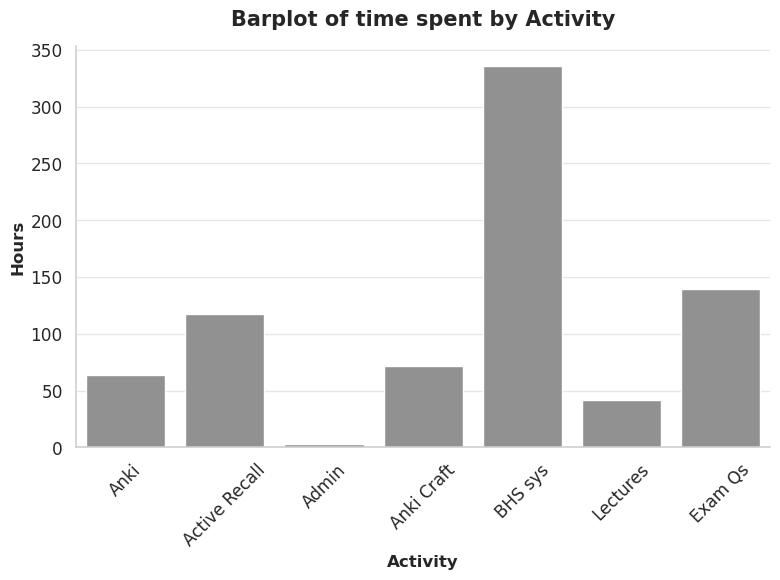

In [5]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=total_by_act,
    x="activity",
    y="time",
    color="#919191F1", 
    edgecolor=None
)

ax.set_xlabel("Activity", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Barplot of time spent by Activity", fontsize=15, weight='bold', pad=15)
ax.tick_params(axis='x', rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/barplot_time_activity.png", dpi=300, bbox_inches="tight")
plt.show()

### Cumulative time per week and activity

Lets create a dataframe grouped by week 

In [6]:
bir_by_date: pd.DataFrame = bir.reset_index().copy()
bir_by_date["date_day"] = pd.to_datetime(bir_by_date["date_day"])
bir_by_date["total_mins"] = bir_by_date.drop(columns="date_day").sum(axis=1)
bir_by_date["total_hours"] = bir_by_date["total_mins"] / 60
bir_gr_week = bir_by_date.copy()
bir_gr_week["week"] = bir_gr_week["date_day"].dt.to_period("W")
bir_gr_week = bir_gr_week.drop(columns=["date_day"])
bir_gr_week = bir_gr_week.groupby("week").sum()
bir_gr_week = bir_gr_week.rename(columns= {
    "01_own": "Anki",
    "active_recall": "Active Recall",
    "admin": "Admin",
    "anki_craft": "Anki Craft",
    "bhs": "BHS sys",
    "lectures": "Lectures",
    "exam_anki": "Exam Qs",
    "total_mins": "Total Hours"
})
bir_gr_week = bir_gr_week.drop(columns=["total_hours"])

In [7]:
activity_cols: list = [c for c in bir_gr_week.columns if c not in {"week"}]
bir_gr_week_cumsum: pd.DataFrame = bir_gr_week.copy()
bir_gr_week_cumsum[activity_cols] = bir_gr_week_cumsum[activity_cols].cumsum().div(60)

2025-11-21 17:23:49,377 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-21 17:23:49,388 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


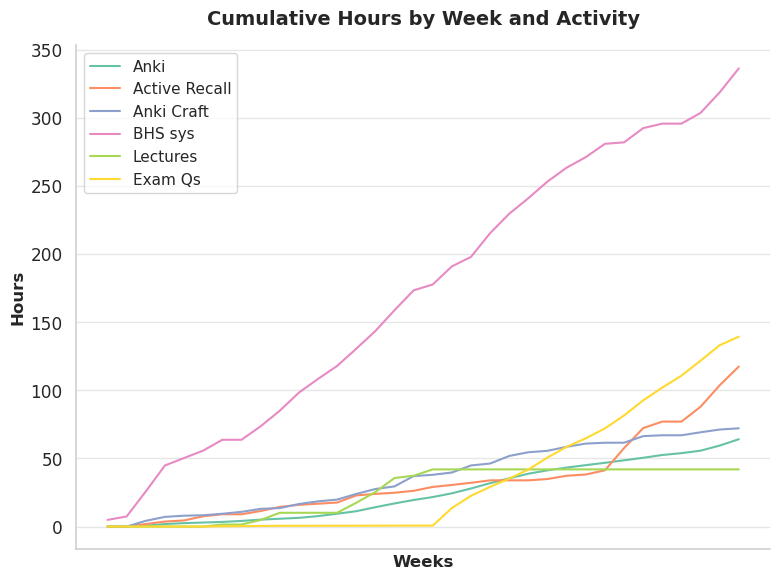

In [8]:
plot_cols: list = [c for c in bir_gr_week_cumsum.columns if c not in {"week", "Total Hours", "Admin"}]

df_long = bir_gr_week_cumsum.reset_index() \
                              .melt(id_vars="week",
                                    value_vars=plot_cols,
                                    var_name="activity",
                                    value_name="hours")

df_long["week"] = df_long["week"].astype(str)
df_long["activity"] = df_long["activity"].astype(str)
df_long = df_long.reset_index(drop=True)


plt.figure(figsize=(8, 6))
ax = sns.lineplot(
        data=df_long,
        x="week",
        y="hours",
        hue="activity",
        linewidth=1.5,
        palette="Set2"
)

ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("Hours", fontsize=12)
ax.set_title("Cumulative Hours by Week and Activity", fontsize=14, weight="bold", pad= 15)
ax.legend(title="", loc="upper left", fontsize=11)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("0.8")
ax.spines["bottom"].set_color("0.8")
ax.grid(axis="y", color="0.9", linewidth=1)
ax.grid(axis="x", visible=False)
ax.set_xticks([])

plt.tight_layout()
plt.savefig("../images/lineplot_cumsum_time_activites.png", dpi=300, bbox_inches="tight")
plt.show()

2025-11-21 17:23:50,240 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-21 17:23:50,255 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


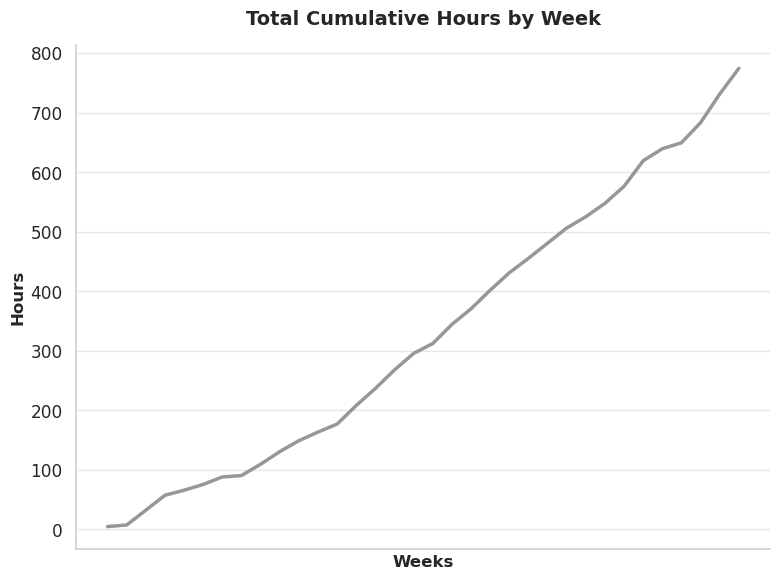

In [9]:
bir_gr_week_cumsum.index = bir_gr_week_cumsum.index.astype(str)

sns.set_theme(
    style="white",
    font_scale=1.1,
    rc={
        "axes.edgecolor": "0.8",
        "axes.linewidth": 1.1,
        "grid.color": "0.9",
        "axes.labelweight": "bold"
    }
)

plt.figure(figsize=(8, 6))
ax = sns.lineplot(
    x=bir_gr_week_cumsum.index,
    y=bir_gr_week_cumsum["Total Hours"],
    color="#919191F1", 
    linewidth=2.5,
)

ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("Hours", fontsize=12)
ax.set_title("Total Cumulative Hours by Week", fontsize=14, weight="bold", pad= 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)
ax.set_xticks([])

plt.tight_layout()
plt.savefig("../images/lineplot_cumsum_time.png", dpi=300, bbox_inches="tight")
plt.show()

### Daily mean vs median study time

First lets create a dataframe with the total time per day

In [10]:
bir_days_hours: pd.DataFrame = bir_by_date.copy()
bir_days_hours = bir_days_hours[["date_day","total_hours"]]
bir_days_hours["total_hours"].describe()

count    228.000000
mean       3.396483
std        2.413007
min        0.030888
25%        1.319954
50%        2.987778
75%        5.251932
max        9.592634
Name: total_hours, dtype: float64

Lets calculate the mean and median per day

In [11]:
mean_h: float = bir_days_hours["total_hours"].mean()
median_h: float = bir_days_hours["total_hours"].median()
print(f"Mean hourns per day: {mean_h:.2f}")
print(f"Median hourns per day: {median_h:.2f}")

Mean hourns per day: 3.40
Median hourns per day: 2.99


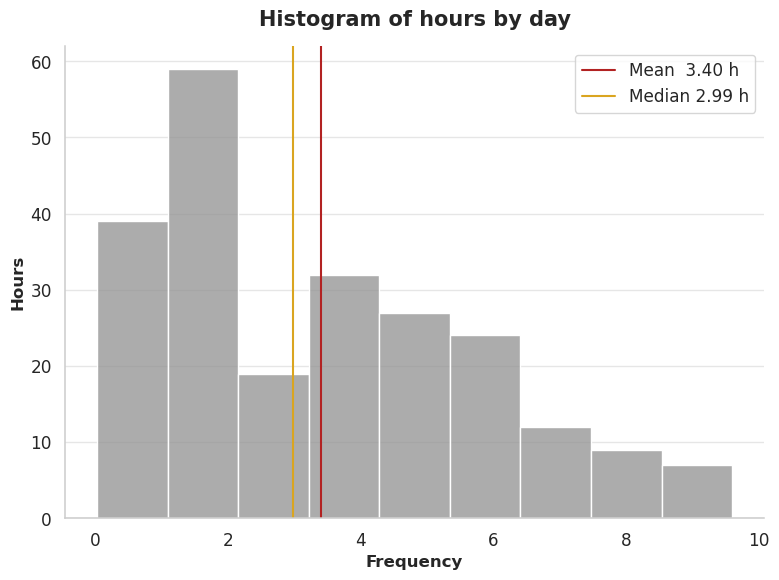

In [12]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.histplot(
    data = bir_days_hours,
    x = "total_hours",
    bins = "auto",
    kde = False,
    color = "#919191F1"
)

ax.axvline(mean_h, color="firebrick", ls='-', lw=1.5, label=f"Mean  {mean_h:.2f} h")
ax.axvline(median_h, color="goldenrod", ls="-", lw=1.5, label=f"Median {median_h:.2f} h")

ax.legend()
ax.set_xlabel("Frequency", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Histogram of hours by day", fontsize=15, weight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/histogram_hours_per_day.png", dpi=300, bbox_inches="tight")
plt.show()

Interpretación

### Efective study days

In [13]:
num_days: int = (datetime(year= 2025, month=1, day=25) - datetime(year= 2024, month=6, day=16)).days + 1
num_days_recorded: int = len(bir_by_date.loc[4:]) 

print(f"The % of efective days is: {(num_days_recorded/num_days)*100:.0f}%")
print(f"Meaning the streak was held for all the {num_days} days")

The % of efective days is: 100%
Meaning the streak was held for all the 224 days


### Standard deviation of daily study time

In [14]:
std_hours_studied: float = bir_days_hours["total_hours"].std(ddof=0)

print(f"The standard deviation of daily study time is: {std_hours_studied:.2f} hours")

The standard deviation of daily study time is: 2.41 hours


### Highest and lowest single-day study time

In [15]:
idx_min_day: int | str = bir_days_hours["total_hours"].idxmin()
idx_max_day: int | str = bir_days_hours["total_hours"].idxmax()

min_day_row: pd.DataFrame | pd.Series = bir_days_hours.loc[idx_min_day]
max_day_row: pd.DataFrame | pd.Series = bir_days_hours.loc[idx_max_day]

print(f"Day with the least time studied: {min_day_row["date_day"]} with {min_day_row["total_hours"]:.2f} hours of study time")
print(f"Day with the most time studied: {max_day_row["date_day"]} with {max_day_row["total_hours"]:.2f} hours of study time")

Day with the least time studied: 2024-07-06 00:00:00 with 0.03 hours of study time
Day with the most time studied: 2025-01-16 00:00:00 with 9.59 hours of study time


### Most and least productive week

In [16]:
idx_min_week: int | str = bir_gr_week["Total Hours"].idxmin()
idx_max_week: int | str = bir_gr_week["Total Hours"].idxmax()

min_week_row: pd.DataFrame | pd.Series = bir_gr_week.loc[idx_min_week]
max_week_row: pd.DataFrame | pd.Series = bir_gr_week.loc[idx_max_week]

print(f"Week with the least time studied: {idx_min_week} with {(min_week_row["Total Hours"] / 60):.2f} hours of study time")
print(f"Week with the most time studied: {idx_max_week} with {(max_week_row["Total Hours"] / 60):.2f} hours of study time")

Week with the least time studied: 2024-07-22/2024-07-28 with 2.26 hours of study time
Week with the most time studied: 2025-01-13/2025-01-19 with 47.97 hours of study time


# Main Questions to Answer

## Wich hours of the day was I more productive?

To answer this question I will create a heatmap where the x parameter is the week days and the y parameter is time spent doing some of the activities

The dataframe needed to answer this question will contain 5 columns:

- `date` being the date in YYYY/MM/DD
- `day_name` being the name of the day
- `hour` bucket containing 1h of the day starting from 5am ending in 1am
- `activity` what was I doing
- `minutes` for how long was I doning it

To achive this I will use the anki dataframe and flowmodor dataframe that has the appropiate info, transform them and merge to achive the desired dataframe

In [17]:
anki_hm: pd.DataFrame = anki.copy()
flow_hm: pd.DataFrame = flowmodoro.copy()

anki_hm = anki_hm.drop(columns=["note_id", "card_id", "tags_list", "pressed", "date_day"])
flow_hm = flow_hm.drop(columns=["accomplished"])

anki_hm["date_reviewed"] = pd.to_datetime(anki_hm["date_reviewed"])
flow_hm["started"] = pd.to_datetime(flow_hm["started"])

In [18]:
anki_hm["date"] = anki_hm["date_reviewed"].dt.date
anki_hm["day_name"] = anki_hm["date_reviewed"].dt.day_name()

flow_hm["date"] = flow_hm["started"].dt.date
flow_hm["day_name"] = flow_hm["started"].dt.day_name()

To simplify the code, and since the anki max response time is 60 seconds, the anki data will be assumed that does not cross hours this way we only need to get the hour started, group by hour and day, sum the seconds and transfrom into minutes

In [19]:
anki_hm["hour"] = anki_hm["date_reviewed"].dt.hour
anki_hm = anki_hm.drop(columns=["date_reviewed"])

In [20]:
anki_hm_gr = (anki_hm.groupby(["date", "day_name", "hour", "deck"], as_index=False)["review_time_seconds"].sum())
anki_hm_gr["review_time_seconds"] = anki_hm_gr["review_time_seconds"].div(60)
anki_hm_gr = anki_hm_gr.rename(columns={"review_time_seconds": "minutes", "deck": "activity"})
# anki_hm_gr["minutes"] = np.floor(anki_hm_gr["minutes"])
anki_hm_gr["activity"] = anki_hm_gr["activity"].map({
    "01_own": "Anki_Review",
    "02_exam": "Anki_Exam_Q",
})
anki_hm_gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1549 non-null   object 
 1   day_name  1549 non-null   object 
 2   hour      1549 non-null   int32  
 3   activity  1549 non-null   object 
 4   minutes   1549 non-null   float64
dtypes: float64(1), int32(1), object(3)
memory usage: 54.6+ KB


For flowmodoro data we need to account that the time spent can be split between more that one hour bucket

In [21]:
flow_hm["end"] = flow_hm["started"] + pd.to_timedelta(flow_hm["mins_worked"], unit="minutes")
flow_hm["hour"] = flow_hm["started"].dt.hour

In [22]:
def split_buckets(row: pd.Series) -> list:
    buckets: list = []
    ts_start: pd.Timestamp = row["started"]
    ts_end: pd.Timestamp = row["end"]
    h_curr: pd.Timestamp = ts_start.floor("h")
    while h_curr < ts_end:
        h_next = h_curr + timedelta(hours=1)
        mins_in = int(
            (min(ts_end, h_next) - max(ts_start, h_curr)).total_seconds() / 60
        )
        buckets.append({
            "date": h_curr.date(),
            "day_name": h_curr.day_name(),
            "hour": h_curr.hour,
            "activity": row["working_on"],
            "minutes": mins_in
        })
        h_curr = h_next
    return buckets

In [23]:
hour_buckets = flow_hm.apply(split_buckets, axis=1).explode(ignore_index=True)
flow_hm_buckets = pd.DataFrame(hour_buckets.tolist())

flow_hm_gr = (flow_hm_buckets.groupby(["date", "day_name", "hour", "activity"], as_index=False)["minutes"].sum())
flow_hm_gr["minutes"] = flow_hm_gr["minutes"].astype(float)
flow_hm_gr["activity"] = flow_hm_gr["activity"].map({
    "active_recall": "Active Recall",
    "admin": "Admin",
    "anki_craft": "Anki Craft",
    "bhs": "BHS sys",
    "lectures": "Lectures",
    "anki_exam": "Exam Qs"
})

flow_hm_gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1329 non-null   object 
 1   day_name  1329 non-null   object 
 2   hour      1329 non-null   int64  
 3   activity  1329 non-null   object 
 4   minutes   1329 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 52.0+ KB


Now that booth df have the same structure lets merge them

In [24]:
hm_df: pd.Series = pd.concat([anki_hm_gr, flow_hm_gr], ignore_index=True)
hm_df["hours"] = hm_df["minutes"] /60
hm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2878 non-null   object 
 1   day_name  2878 non-null   object 
 2   hour      2878 non-null   int64  
 3   activity  2878 non-null   object 
 4   minutes   2878 non-null   float64
 5   hours     2878 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 135.0+ KB


Finally lets do the heatmap

### Global Heatmap

To do the heatmap lets pivot the dataframe to obtain a dataframe where the columns are the hour buckets, the rows are the weekdays 

In [25]:
pivot_total: pd.DataFrame = (hm_df.pivot_table(index="hour",
                              columns="day_name",
                              values="hours",
                              aggfunc="sum")
                .reindex(columns=["Monday", "Tuesday", "Wednesday",
                      "Thursday", "Friday", "Saturday", "Sunday"])
                .reindex(index=range(5, 24)))

pivot_norm: pd.DataFrame = pivot_total.div(pivot_total.max().max()) 
pivot_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 5 to 23
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Monday     17 non-null     float64
 1   Tuesday    17 non-null     float64
 2   Wednesday  18 non-null     float64
 3   Thursday   18 non-null     float64
 4   Friday     18 non-null     float64
 5   Saturday   18 non-null     float64
 6   Sunday     17 non-null     float64
dtypes: float64(7)
memory usage: 1.2 KB


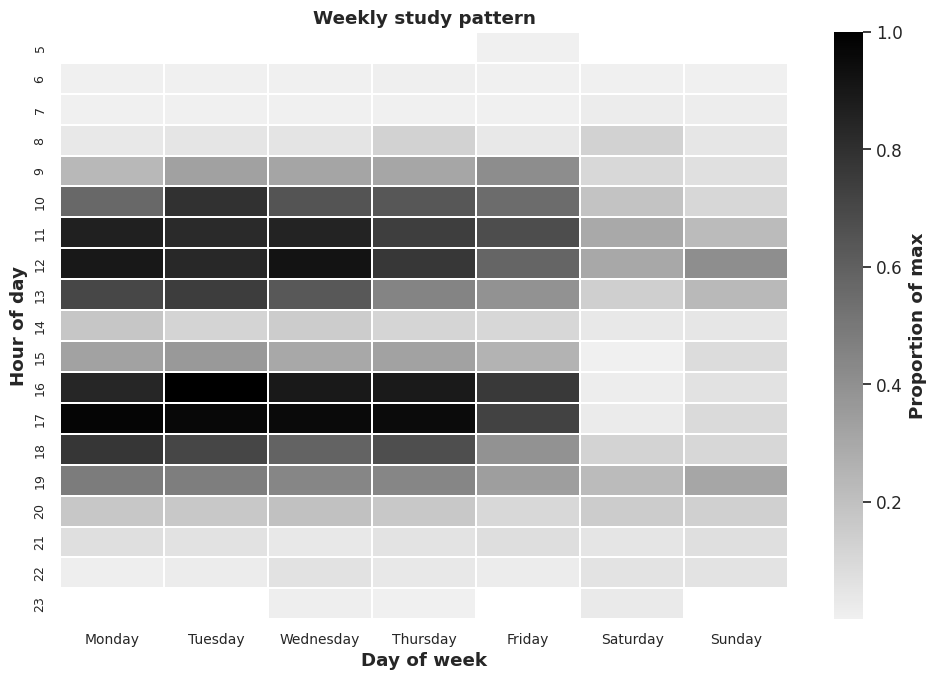

In [69]:
grey_grad = LinearSegmentedColormap.from_list(
    "grey_grad",
    ["#F0F0F0",
     '#000000']
)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(pivot_norm,
                 cmap=grey_grad,
                 linewidths=.3,
                 cbar_kws={"label": "Proportion of max"})

ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=10)
plt.ylabel("Hour of day")
plt.xlabel("Day of week")
plt.title("Weekly study pattern", weight="bold")
plt.tight_layout()
plt.savefig("../images/heatmap_global.png", dpi=300)
plt.show()

Comentario + visual, mas buscar en el df franja horaria mas productiva y top 5

### By Activity Heatmaps

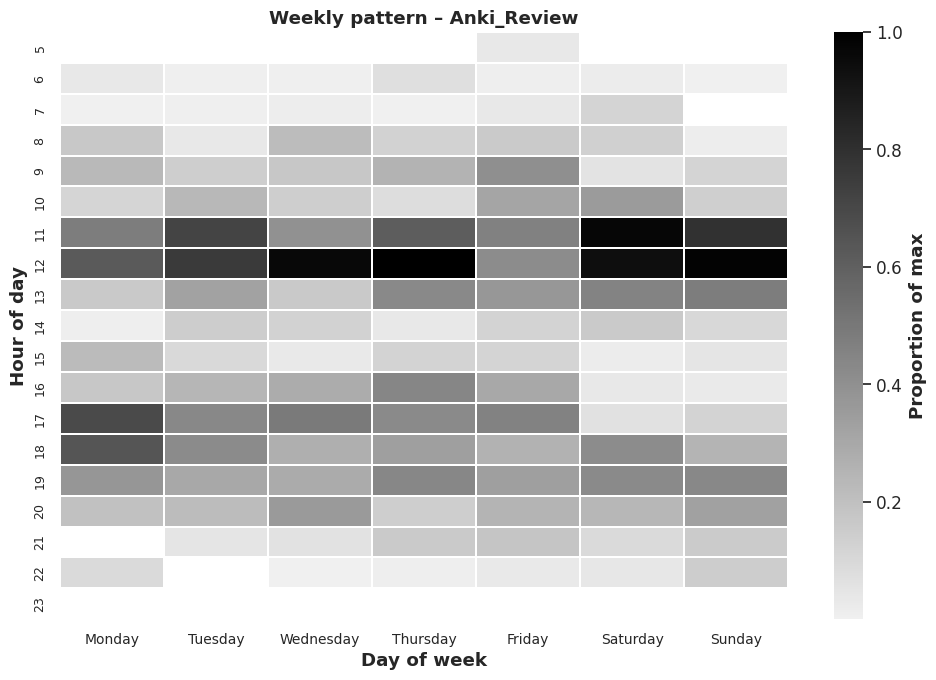

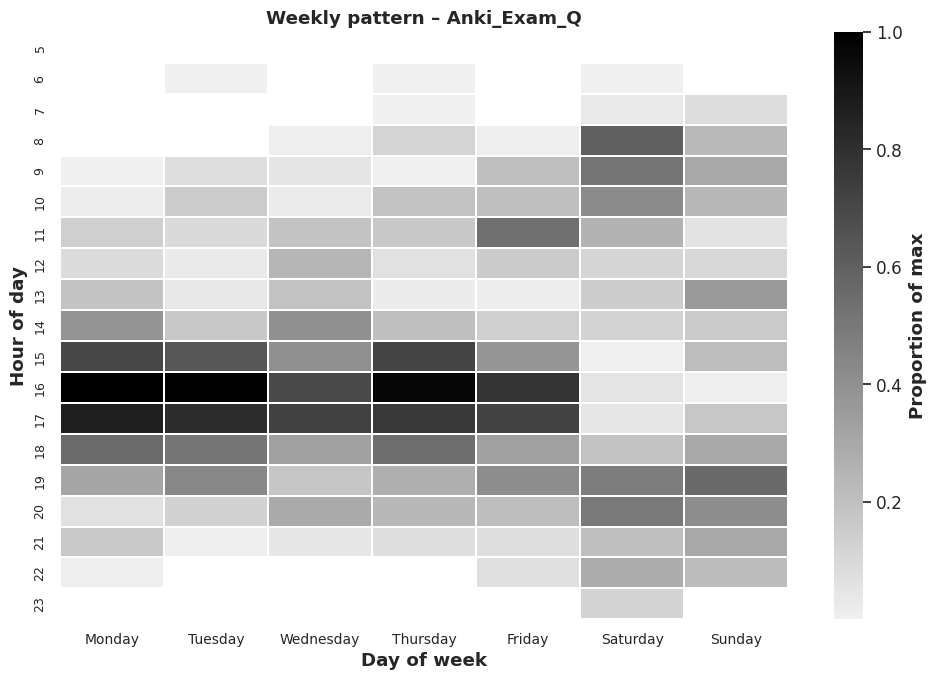

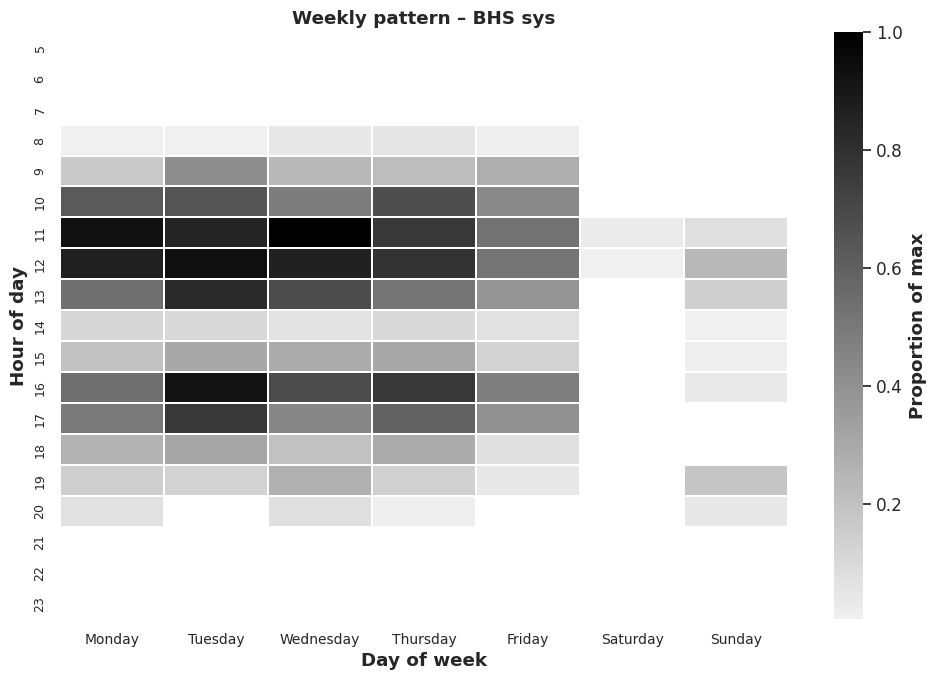

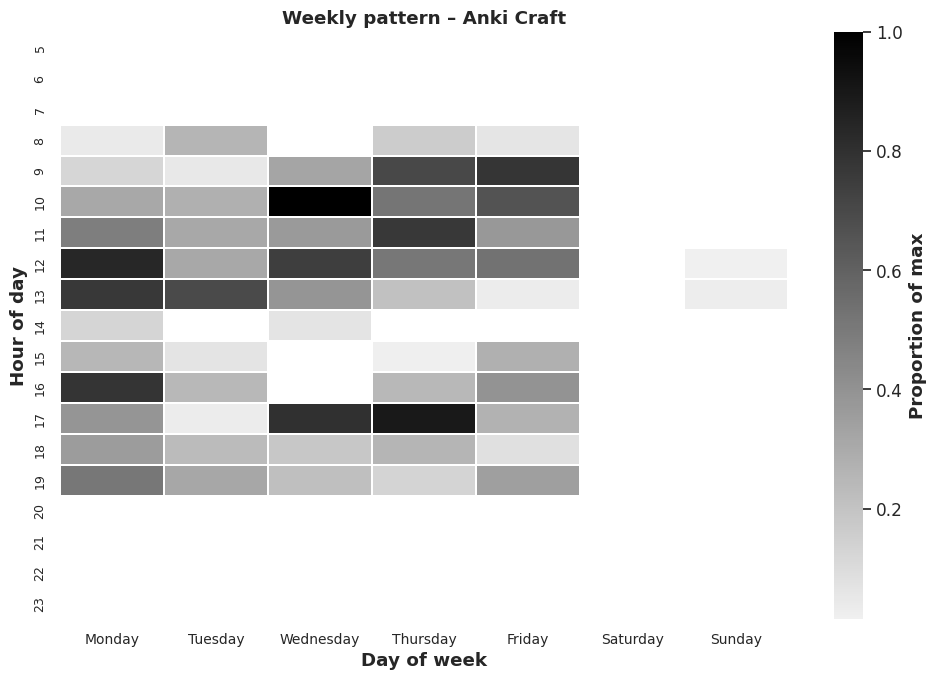

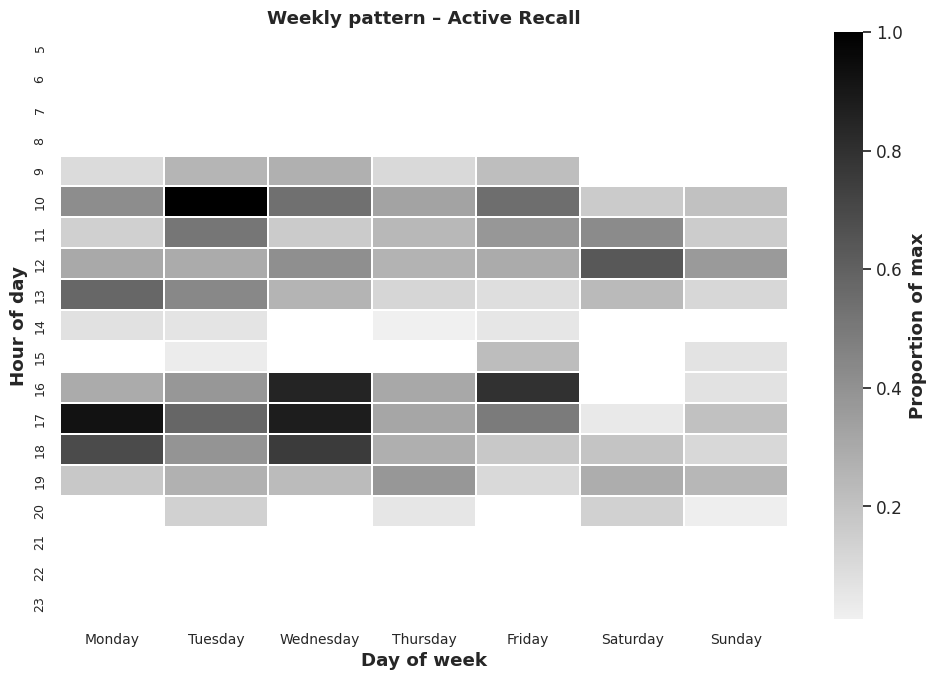

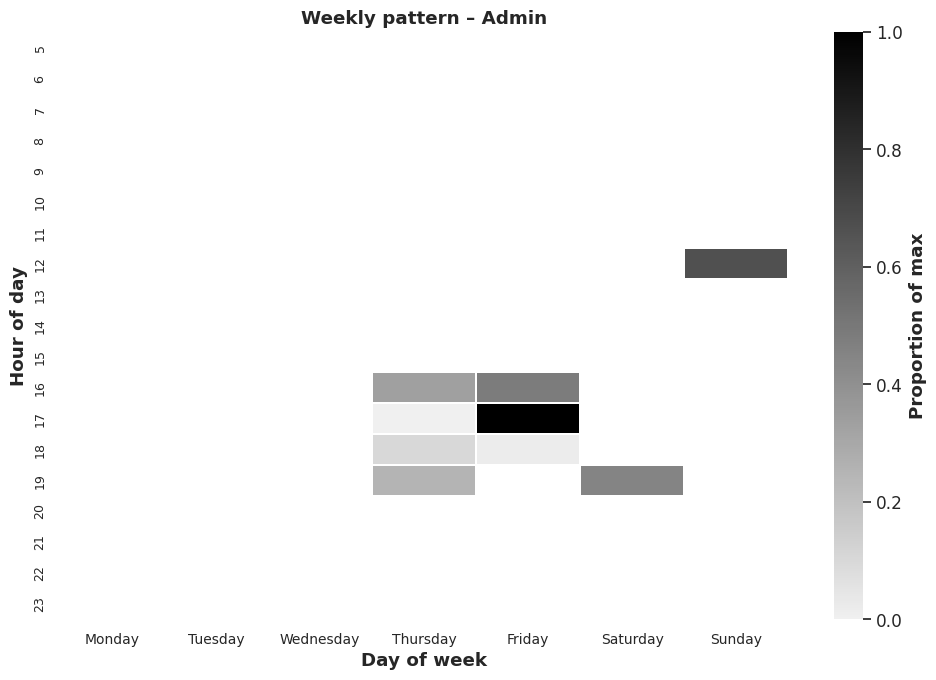

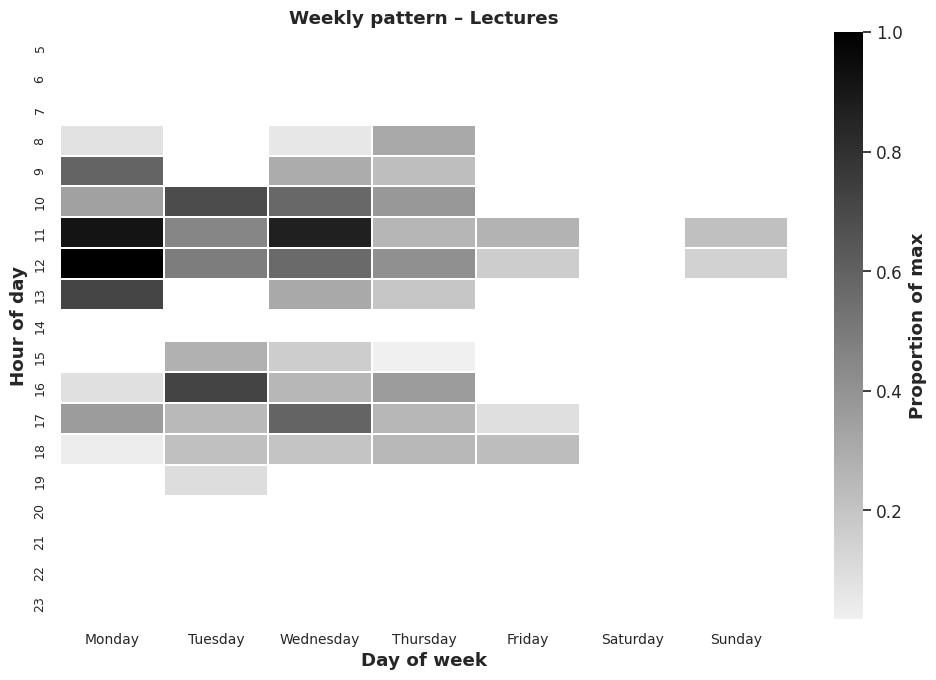

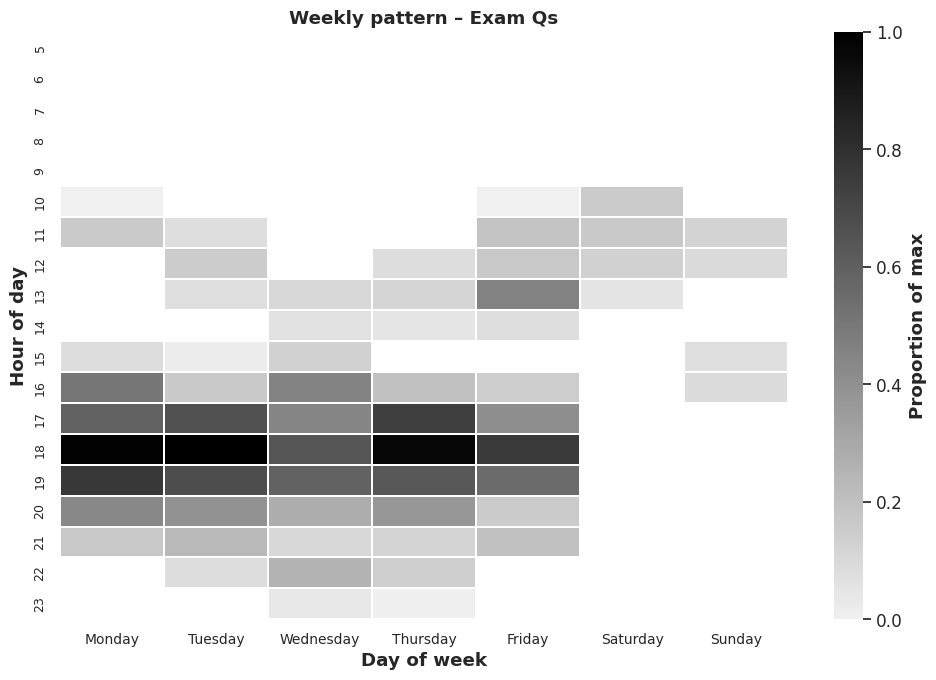

In [27]:
activities: list = hm_df["activity"].unique()

for act in activities:
    pivot_act: pd.DataFrame = (
        hm_df[hm_df["activity"].eq(act)]
        .pivot_table(index= "hour",
                     columns = "day_name",
                     values = "hours",
                     aggfunc = "sum")
                    .reindex(columns=["Monday", "Tuesday", "Wednesday", 
                                      "Thursday", "Friday", "Saturday", "Sunday"])
                    .reindex(index=range(5,24))
    )
    pivot_act_norm: pd.DataFrame = pivot_act.div(pivot_act.max().max())

    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(pivot_act_norm,
                cmap=grey_grad,
                linewidths=.3,
                cbar_kws={"label": "Proportion of max"})

    
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', labelsize=10)
    
    plt.title(f"Weekly pattern – {act}", weight="bold")
    plt.ylabel("Hour of day")
    plt.xlabel("Day of week")
    plt.tight_layout()
    plt.savefig(f"../images/heatmap_{act}.png", dpi=300)
    plt.show()


## Anki Related Questions

### Diferences between reviewing cards vs creating them

#### Time wise

To answer this I will reuse the df used in the cumulative time 

In [28]:
anki_time: pd.DataFrame = bir_by_date.copy()
anki_time = anki_time.drop(columns=["active_recall", "admin", "bhs", "lectures", "exam_anki", "total_mins", "total_hours"])
anki_time = anki_time[~((anki_time[["01_own", "anki_craft"]] == 0).all(axis=1))].reset_index(drop=True)
anki_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_day    223 non-null    datetime64[ns]
 1   01_own      223 non-null    float64       
 2   anki_craft  223 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 5.4 KB


In [29]:
anki_time_cm: pd.DataFrame = anki_time.copy()
anki_time_cm["01_own"] = anki_time_cm["01_own"].cumsum()
anki_time_cm["anki_craft"] = anki_time_cm["anki_craft"].cumsum()
anki_time_cm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_day    223 non-null    datetime64[ns]
 1   01_own      223 non-null    float64       
 2   anki_craft  223 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 5.4 KB


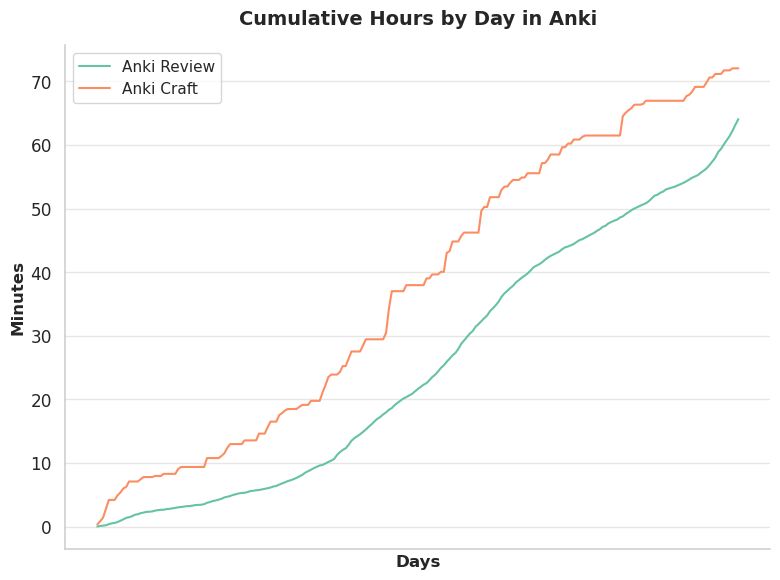

In [30]:
df_long_anki = anki_time_cm.reset_index() \
                              .melt(id_vars="date_day",
                                    value_vars=["01_own", "anki_craft"],
                                    var_name="activity",
                                    value_name="minutes")

df_long_anki["activity"] = df_long_anki["activity"].map({
        "01_own": "Anki Review",
        "anki_craft": "Anki Craft"
})

df_long_anki["activity"] = df_long_anki["activity"].astype(str)
df_long_anki["hours"] = df_long_anki["minutes"].div(60)

plt.figure(figsize=(8, 6))
ax = sns.lineplot(
        data=df_long_anki,
        x="date_day",
        y="hours",
        hue="activity",
        linewidth=1.5,
        palette="Set2"
)

ax.set_xlabel("Days", fontsize=12)
ax.set_ylabel("Minutes", fontsize=12)
ax.set_title("Cumulative Hours by Day in Anki", fontsize=14, weight="bold", pad= 15)
ax.legend(title="", loc="upper left", fontsize=11)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("0.8")
ax.spines["bottom"].set_color("0.8")
ax.grid(axis="y", color="0.9", linewidth=1)
ax.grid(axis="x", visible=False)
ax.set_xticks([])

plt.tight_layout()
plt.savefig("../images/lineplot_cumsum_time_anki.png", dpi=300, bbox_inches="tight")
plt.show()

In [31]:
total_time_review: float = anki_time["01_own"].sum()
total_time_craft: float = anki_time["anki_craft"].sum()

anki_time_dif: pd.DataFrame = anki_time_cm.copy()
anki_time_dif["diff"] = anki_time_dif["01_own"] - anki_time_dif["anki_craft"]
anki_time_dif["date_day"] = anki_time_dif["date_day"].dt.strftime('%Y-%m-%d')

max_anki_diff = anki_time_dif.iloc[30:]["diff"].pipe(lambda x: anki_time_dif.loc[x.idxmax()])
min_anki_diff: pd.Series | pd.DataFrame = anki_time_dif.loc[anki_time_dif["diff"].idxmin()]


print(f"Total time spent creating cards = {total_time_craft/60:.2f} hours")
print(f"Total time spent reviewing cards = {total_time_review/60:.2f} hours")
print(f"Total time spent in anki = {(total_time_craft + total_time_review)/60:.2f} hours")
print(f"Time spent reviewing vs creating = {(total_time_review - total_time_craft)/60:.2f} hours")

print(f"The minumun time diference (excluding first 30 days) was {max_anki_diff["date_day"]} with a value of {max_anki_diff["diff"]:.2f} minutes")
print(f"The maximum time diference was {min_anki_diff["date_day"]} with a value of {min_anki_diff["diff"]:.2f} minutes ({min_anki_diff["diff"]/60:.2f} hours)")

Total time spent creating cards = 72.07 hours
Total time spent reviewing cards = 64.08 hours
Total time spent in anki = 136.15 hours
Time spent reviewing vs creating = -7.99 hours
The minumun time diference (excluding first 30 days) was 2024-07-24 with a value of -350.70 minutes
The maximum time diference was 2024-09-27 with a value of -1102.78 minutes (-18.38 hours)


#### Cards wise

Using the anki dataframe and the fact that card_id is the unix timestamp when it was created we can know all the creation times of cards and know how many cards were created in a day, then with the date_reviewed we can know how many cards where reviewed in a day

In [32]:
anki_copy: pd.DataFrame = anki.copy()
own_mask = anki_copy["deck"].str.contains("01_own")
anki_own: pd.DataFrame = anki_copy[own_mask]

created_cards: pd.Series = anki_own["card_id"]
created_cards = created_cards.drop_duplicates().reset_index(drop=True)
created_cards_date = pd.to_datetime(created_cards, unit='ms').dt.date

created_day: pd.DataFrame = (
    created_cards_date
    .value_counts()
    .reset_index()
    .rename(columns={"index": "date", 0: "num"})
)
created_day = created_day.rename(columns={"card_id": "day"})
created_day["action"] = "Created"
created_day_cm = created_day.copy()
created_day_cm = created_day_cm.sort_values("day").reset_index(drop=True)
created_day_cm["count"] = created_day_cm["count"].cumsum()
created_day_cm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     92 non-null     object
 1   count   92 non-null     int64 
 2   action  92 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.3+ KB


In [33]:
reviewed_cards: pd.Series = anki_own["date_reviewed"].dt.date
reviewed_day: pd.DataFrame = (
    reviewed_cards
    .value_counts()
    .reset_index()
    .rename(columns={"index": "date", 0: "num"})
)
reviewed_day = reviewed_day.rename(columns={"date_reviewed": "day"})
reviewed_day["action"] = "Reviewed"
reviewed_day_cm = reviewed_day.copy()
reviewed_day_cm = reviewed_day_cm.sort_values("day").reset_index(drop=True)
reviewed_day_cm["count"] = reviewed_day_cm["count"].cumsum()
reviewed_day_cm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     222 non-null    object
 1   count   222 non-null    int64 
 2   action  222 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.3+ KB


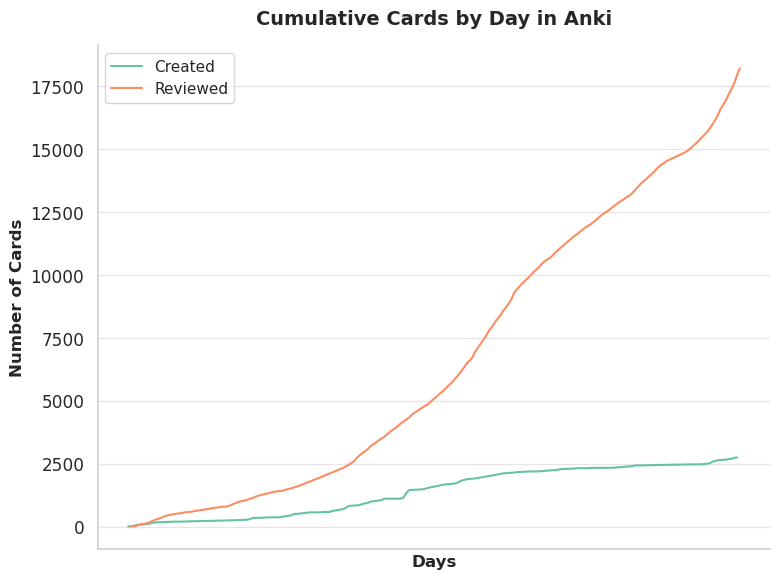

In [34]:
anki_cards: pd.DataFrame = pd.concat([created_day_cm, reviewed_day_cm], ignore_index= True)

plt.figure(figsize=(8, 6))
ax = sns.lineplot(
        data=anki_cards,
        x="day",
        y="count",
        hue="action",
        linewidth=1.5,
        palette="Set2"
)

ax.set_xlabel("Days", fontsize=12)
ax.set_ylabel("Number of Cards", fontsize=12)
ax.set_title("Cumulative Cards by Day in Anki", fontsize=14, weight="bold", pad= 15)
ax.legend(title="", loc="upper left", fontsize=11)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("0.8")
ax.spines["bottom"].set_color("0.8")
ax.grid(axis="y", color="0.9", linewidth=1)
ax.grid(axis="x", visible=False)
ax.set_xticks([])

plt.tight_layout()
plt.savefig("../images/lineplot_cumsum_cards_anki.png", dpi=300, bbox_inches="tight")
plt.show()

In [35]:
total_cards_created: int = created_day["count"].sum()
total_cards_reviewed: int = reviewed_day["count"].sum()
max_day_create: pd.Series | pd.DataFrame = created_day.loc[created_day["count"].idxmax()]
min_day_create: pd.Series | pd.DataFrame = created_day.loc[created_day["count"].idxmin()]
max_day_review: pd.Series | pd.DataFrame = reviewed_day.loc[reviewed_day["count"].idxmax()]
min_day_review: pd.Series | pd.DataFrame = reviewed_day.loc[reviewed_day["count"].idxmin()]

print(f"The total number of created cards is: {total_cards_created} cards")
print(f"The total number of reviewed cards is: {total_cards_reviewed} cards")
print(f"The day with most created cards is {max_day_create["day"]} with {max_day_create["count"]} cards")
print(f"The day with most reviewed cards is {max_day_review["day"]} with {max_day_review["count"]} cards")

The total number of created cards is: 2761 cards
The total number of reviewed cards is: 18220 cards
The day with most created cards is 2024-09-26 with 184 cards
The day with most reviewed cards is 2025-01-24 with 336 cards


### Is the top 10 more cards deck the same as top 10 more time deck?

#### Dataframe cleaning and preparation

In [36]:
own_mask = anki_copy["deck"].str.contains("01_own")
anki_decks = anki_copy[own_mask]
anki_decks = anki_decks[["card_id","tags_list", "pressed", "date_reviewed", "date_day", "review_time_seconds"]]
anki_decks["pressed"] = anki_decks["pressed"].map({
    1: 0,
    2: 0.5,
    3: 1,
    4: 1.25
})
anki_decks["month"] = anki_decks["date_reviewed"].dt.month_name()

In [37]:
def get_deck(lst: list) -> str:
    filter_words = {"00Daily", "leech"}
    lst_filtered = [i for i in lst if not any(w in i for w in filter_words)]
    if len(lst_filtered) == 0:
        return "Missing"
    else:
        if "::" in lst_filtered[0]:
            return lst_filtered[0].split("::")[0]
        else:
            return lst_filtered[0]

In [38]:
anki_decks["deck"] = anki_decks["tags_list"].apply(lambda lst: get_deck(lst))
anki_decks = anki_decks.drop(columns=["tags_list"])
anki_decks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18220 entries, 0 to 20365
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   card_id              18220 non-null  int64         
 1   pressed              18220 non-null  float64       
 2   date_reviewed        18220 non-null  datetime64[ns]
 3   date_day             18220 non-null  object        
 4   review_time_seconds  18220 non-null  float64       
 5   month                18220 non-null  object        
 6   deck                 18220 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.1+ MB


#### Top 10 more cards decks

In [39]:
anki_decks_top_cards: pd.DataFrame = anki_decks.copy()
anki_decks_top_cards = anki_decks_top_cards.drop_duplicates(subset=["card_id"], keep="last").reset_index(drop=True)
anki_decks_top_cards = (anki_decks_top_cards.groupby(["deck"], as_index= False).size())
missing_mask = ~anki_decks_top_cards["deck"].str.contains("Missing")
anki_decks_top_cards = anki_decks_top_cards[missing_mask]

In [40]:
anki_decks_top_ten_cards: pd.DataFrame = anki_decks_top_cards.nlargest(10, "size").reset_index(drop=True)
anki_decks_top_ten_cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   deck    10 non-null     object
 1   size    10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 292.0+ bytes


#### Top 10 more time decks

In [41]:
anki_decks_top_time = anki_decks.copy()
anki_decks_top_time = (anki_decks_top_time.groupby(["deck"], as_index= False)["review_time_seconds"].sum())
missing_mask = ~anki_decks_top_time["deck"].str.contains("Missing")
anki_decks_top_time["hours"] = anki_decks_top_time["review_time_seconds"].div(60).div(60)
anki_decks_top_time = anki_decks_top_time.drop(columns=["review_time_seconds"])
anki_decks_top_time = anki_decks_top_time[missing_mask]

In [42]:
anki_decks_top_ten_time = anki_decks_top_time.nlargest(10, "hours").reset_index(drop=True)
anki_decks_top_ten_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   deck    10 non-null     object 
 1   hours   10 non-null     float64
dtypes: float64(1), object(1)
memory usage: 292.0+ bytes


#### Comparaison

In [43]:
for n, row in enumerate(anki_decks_top_ten_cards.itertuples(index=False), start=1):
    print(f"Top {n:02d} deck with more cards: {row.deck} with {row.size} cards")

Top 01 deck with more cards: Bacteriologia with 263 cards
Top 02 deck with more cards: Nervioso with 211 cards
Top 03 deck with more cards: Inmunologia with 189 cards
Top 04 deck with more cards: Parasitologia with 147 cards
Top 05 deck with more cards: Hematologia with 145 cards
Top 06 deck with more cards: Fallos with 128 cards
Top 07 deck with more cards: Virologia with 124 cards
Top 08 deck with more cards: Patologias_Mutaciones with 122 cards
Top 09 deck with more cards: Tecnicas with 105 cards
Top 10 deck with more cards: Lista_Compra with 66 cards


In [44]:
for n, row in enumerate(anki_decks_top_ten_time.itertuples(index=False), start=1):
    print(f"Top {n:02d} deck with more time: {row.deck} with {row.hours:.2f} hours")

Top 01 deck with more time: Bacteriologia with 7.95 hours
Top 02 deck with more time: Nervioso with 5.32 hours
Top 03 deck with more time: Parasitologia with 4.14 hours
Top 04 deck with more time: Inmunologia with 4.02 hours
Top 05 deck with more time: Hematologia with 3.22 hours
Top 06 deck with more time: Virologia with 2.69 hours
Top 07 deck with more time: Patologias_Mutaciones with 2.60 hours
Top 08 deck with more time: Tecnicas with 2.46 hours
Top 09 deck with more time: Antiinfecciosos with 2.22 hours
Top 10 deck with more time: Endocrinologia with 1.65 hours


### Evolution of success rate of cards created by me

#### By Month

In [45]:
anki_decks_sr = anki_decks.copy()
order = ["June", "July", "August", "September", "October", "November", "December", "January"]
anki_decks_sr["month"] = pd.Categorical(anki_decks_sr["month"], categories=order, ordered=True)
anki_decks_sr_m = anki_decks_sr.copy()
anki_decks_sr_m = (anki_decks_sr_m.groupby(["month"], observed= True, as_index= False)["pressed"].mean())
anki_decks_sr_m["pressed"] = anki_decks_sr_m["pressed"] * 100
anki_decks_sr_m.head()

,month,pressed
0,June,81.370192
1,July,83.526012
2,August,85.590909
3,September,78.117207
4,October,76.921618


2025-11-21 17:24:03,306 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-21 17:24:03,316 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


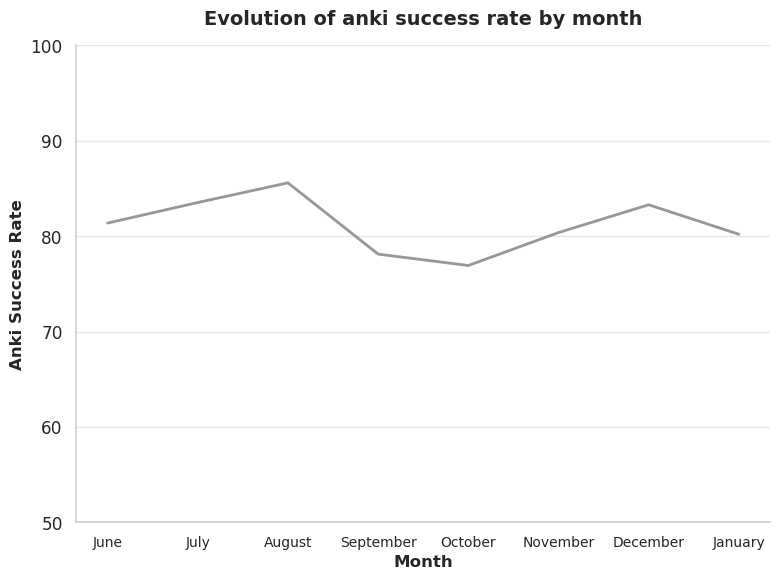

In [46]:
plt.figure(figsize=(8, 6))
ax = sns.lineplot(
        data=anki_decks_sr_m,
        x="month",
        y="pressed",
        linewidth=2,
        color = "#919191F1"
)

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Anki Success Rate", fontsize=12)
ax.set_title("Evolution of anki success rate by month", fontsize=14, weight="bold", pad= 15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("0.8")
ax.spines["bottom"].set_color("0.8")
ax.grid(axis="y", color="0.9", linewidth=1)
ax.grid(axis="x", visible=False)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylim(50, 100)
plt.tight_layout()
plt.savefig("../images/lineplot_evolution_anki_global_success_rate.png", dpi=300, bbox_inches="tight")
plt.show()

#### By Hour of the Day

In [47]:
anki_decks_sr_h = anki_decks_sr.copy()
anki_decks_sr_h["hour"] = anki_decks_sr_h["date_reviewed"].dt.hour
anki_decks_sr_h = (anki_decks_sr_h.groupby(["hour"], observed=True, as_index=False)["pressed"].mean())
anki_decks_sr_h["pressed"] = anki_decks_sr_h["pressed"] *100
anki_decks_sr_h["hour"] = anki_decks_sr_h["hour"].astype(int)
anki_decks_sr_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hour     18 non-null     int64  
 1   pressed  18 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 420.0 bytes


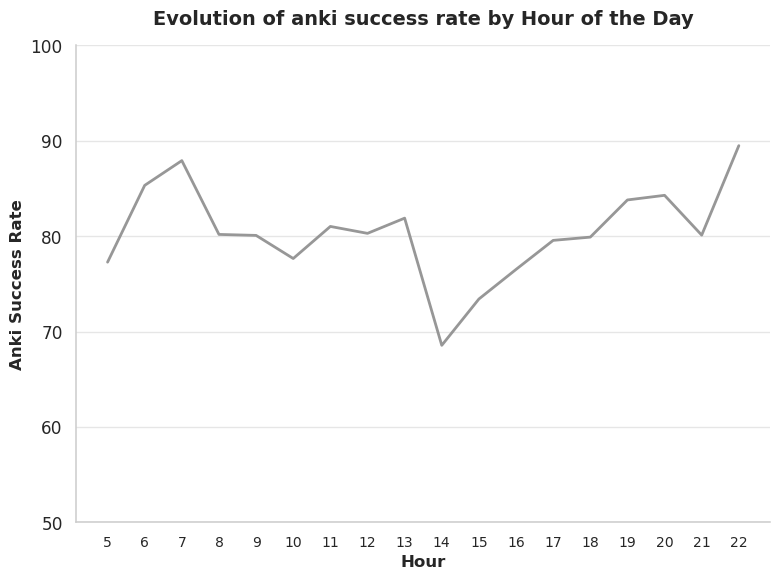

In [48]:
plt.figure(figsize=(8, 6))
ax = sns.lineplot(
        data=anki_decks_sr_h,
        x="hour",
        y="pressed",
        linewidth=2,
        color = "#919191F1"
)

ticks = sorted(anki_decks_sr_h["hour"].unique())
ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("Anki Success Rate", fontsize=12)
ax.set_title("Evolution of anki success rate by Hour of the Day", fontsize=14, weight="bold", pad= 15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("0.8")
ax.spines["bottom"].set_color("0.8")
ax.grid(axis="y", color="0.9", linewidth=1)
ax.grid(axis="x", visible=False)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylim(50, 100)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

plt.tight_layout()
plt.savefig("../images/lineplot_evolution_anki_hour_success_rate.png", dpi=300, bbox_inches="tight")
plt.show()

### Evolution of success rate of exam cards

In [49]:
exam_mask = anki_copy["deck"].str.contains("02_exam")
anki_exam = anki_copy[exam_mask]
anki_exam = anki_exam[["card_id","tags_list", "pressed", "date_reviewed", "date_day", "review_time_seconds"]]
anki_exam["pressed"] = anki_exam["pressed"].map({
    1: 0,
    2: 0.5,
    3: 1,
    4: 1.25
})
anki_exam["month"] = anki_exam["date_reviewed"].dt.month_name()
anki_exam["hour"] = anki_exam["date_reviewed"].dt.hour
anki_exam["month"] = pd.Categorical(anki_exam["month"], categories=order, ordered=True)
anki_exam = anki_exam.dropna(subset=["pressed"]).reset_index(drop=True)
anki_exam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31717 entries, 0 to 31716
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   card_id              31717 non-null  int64         
 1   tags_list            31717 non-null  object        
 2   pressed              31717 non-null  float64       
 3   date_reviewed        31717 non-null  datetime64[ns]
 4   date_day             31717 non-null  object        
 5   review_time_seconds  31717 non-null  float64       
 6   month                31717 non-null  category      
 7   hour                 31717 non-null  int32         
dtypes: category(1), datetime64[ns](1), float64(2), int32(1), int64(1), object(2)
memory usage: 1.6+ MB


#### By Month

In [50]:
anki_exam_sr_m = anki_exam.copy()
anki_exam_sr_m = anki_exam_sr_m.groupby(["month"], observed=True, as_index=False)["pressed"].mean()
anki_exam_sr_m["pressed"] = anki_exam_sr_m["pressed"] *100
anki_exam_sr_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   month    7 non-null      category
 1   pressed  7 non-null      float64 
dtypes: category(1), float64(1)
memory usage: 559.0 bytes


2025-11-21 17:24:04,872 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-11-21 17:24:04,888 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


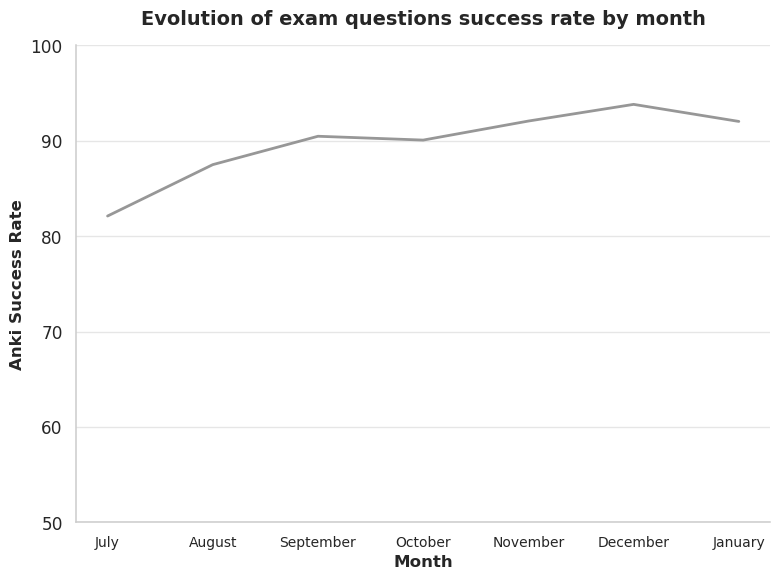

In [51]:
plt.figure(figsize=(8, 6))
ax = sns.lineplot(
        data=anki_exam_sr_m,
        x="month",
        y="pressed",
        linewidth=2,
        color = "#919191F1"
)

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Anki Success Rate", fontsize=12)
ax.set_title("Evolution of exam questions success rate by month", fontsize=14, weight="bold", pad= 15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("0.8")
ax.spines["bottom"].set_color("0.8")
ax.grid(axis="y", color="0.9", linewidth=1)
ax.grid(axis="x", visible=False)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylim(50, 100)
plt.tight_layout()
plt.savefig("../images/lineplot_evolution_anki_exam_global_success_rate.png", dpi=300, bbox_inches="tight")
plt.show()

#### By hour of the Day

In [52]:
anki_exam_sr_h = anki_exam.copy()
anki_exam_sr_h = anki_exam_sr_h.groupby(["hour"], observed=True, as_index=False)["pressed"].mean()
anki_exam_sr_h["pressed"] = anki_exam_sr_h["pressed"] *100
anki_exam_sr_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hour     18 non-null     int32  
 1   pressed  18 non-null     float64
dtypes: float64(1), int32(1)
memory usage: 348.0 bytes


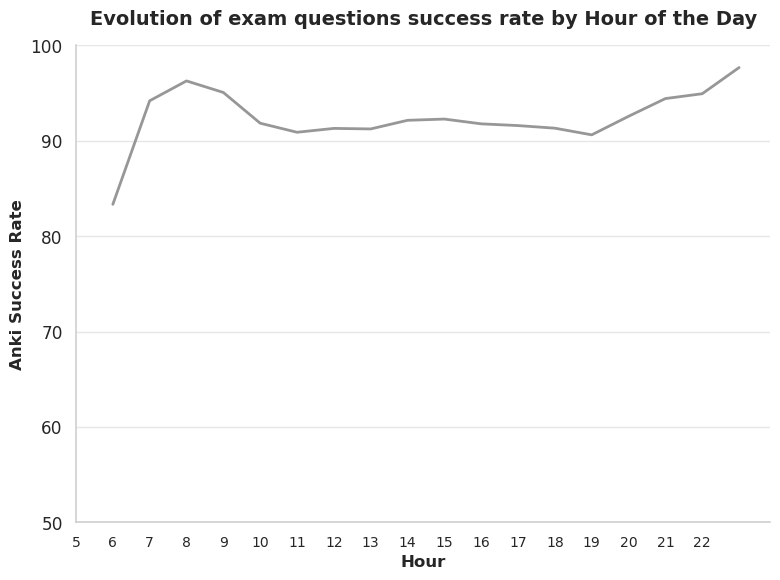

In [53]:
plt.figure(figsize=(8, 6))
ax = sns.lineplot(
        data=anki_exam_sr_h,
        x="hour",
        y="pressed",
        linewidth=2,
        color = "#919191F1"
)

ticks = sorted(anki_decks_sr_h["hour"].unique())
ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("Anki Success Rate", fontsize=12)
ax.set_title("Evolution of exam questions success rate by Hour of the Day", fontsize=14, weight="bold", pad= 15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("0.8")
ax.spines["bottom"].set_color("0.8")
ax.grid(axis="y", color="0.9", linewidth=1)
ax.grid(axis="x", visible=False)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylim(50, 100)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

plt.tight_layout()
plt.savefig("../images/lineplot_evolution_anki_exam_hour_success_rate.png", dpi=300, bbox_inches="tight")
plt.show()

## Evolution of the time studied by month

In [54]:
study_month = bir_days_hours.copy()
study_month["month"] = study_month["date_day"].dt.month_name()
study_month = study_month[~study_month["month"].str.contains("May")].reset_index(drop=True)
study_month = study_month.drop(columns=["date_day"])
study_month["month"] = pd.Categorical(study_month["month"], categories=order, ordered=True)
study_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   total_hours  224 non-null    float64 
 1   month        224 non-null    category
dtypes: category(1), float64(1)
memory usage: 2.5 KB


In [55]:
study_month_group = study_month.groupby(["month"], as_index= False, observed=True)["total_hours"].sum()
study_month_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   month        8 non-null      category
 1   total_hours  8 non-null      float64 
dtypes: category(1), float64(1)
memory usage: 568.0 bytes


2025-11-21 17:29:23,245 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-21 17:29:23,257 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


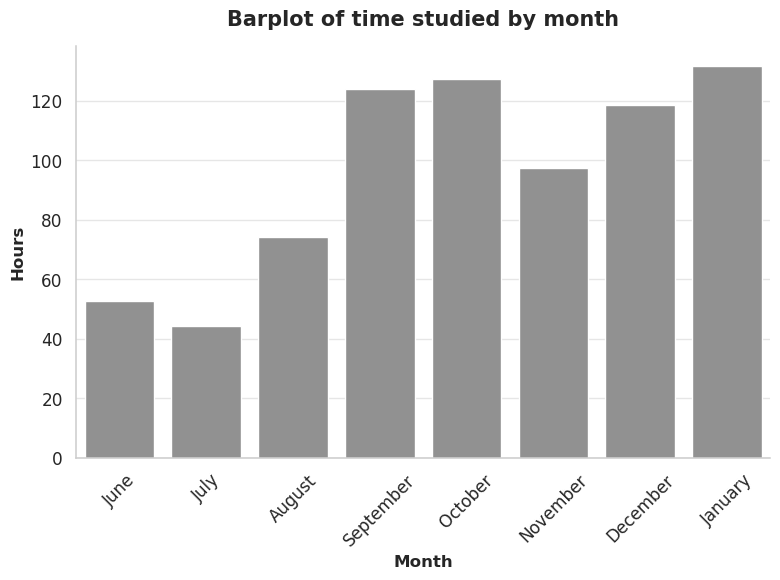

In [71]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=study_month_group,
    x="month",
    y="total_hours",
    color="#919191F1", 
    edgecolor=None
)

ax.set_xlabel("Month", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Barplot of time studied by month", fontsize=15, weight='bold', pad=15)
ax.tick_params(axis='x', rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/barplot_total_time_month.png", dpi=300, bbox_inches="tight")
plt.show()

### Two distinc populations?

In the histogram of study time by day its seems like the population is bimodal, watching the barplot of time per month seems to coroborate this hipothesis.

Lets split the time spent studying in one population from june to august and the other one september to january

In [57]:
group_1 = study_month["month"].isin(["June", "July", "August"])
study_month_1 = study_month[group_1]
study_month_2 = study_month[~group_1]

#### Population 1

In [58]:
mean_h1: float = study_month_1["total_hours"].mean()
median_h1: float = study_month_1["total_hours"].median()
print(f"Mean hourns per day: {mean_h1:.2f}")
print(f"Median hourns per day: {median_h1:.2f}")

Mean hourns per day: 2.22
Median hourns per day: 2.11


In [59]:
study_month_1.describe()

activity,total_hours
count,77.000000
mean,2.217344
std,1.573407
min,0.030888
25%,0.967134
50%,2.114898
75%,3.526342
max,5.750000


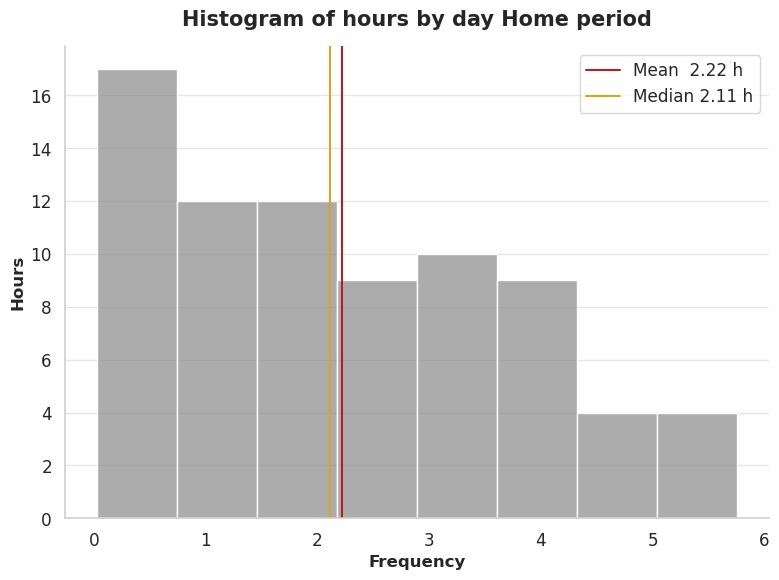

In [60]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.histplot(
    data = study_month_1,
    x = "total_hours",
    bins = "auto",
    kde = False,
    color = "#919191F1"
)

ax.axvline(mean_h1, color="firebrick", ls='-', lw=1.5, label=f"Mean  {mean_h1:.2f} h")
ax.axvline(median_h1, color="goldenrod", ls="-", lw=1.5, label=f"Median {median_h1:.2f} h")

ax.legend()
ax.set_xlabel("Frequency", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Histogram of hours by day Home period", fontsize=15, weight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/histogram_hours_per_day_p1.png", dpi=300, bbox_inches="tight")
plt.show()

Save the data in parquet file for further statistical analysis

In [61]:
p1_path: str = "../data/p1.parquet"
study_month_1.to_parquet(p1_path)
logging.info(f"Saved data in {p1_path}")

2025-11-21 17:24:09,008 - INFO - Saved data in ../data/p1.parquet


#### Population 2

In [62]:
mean_h2: float = study_month_2["total_hours"].mean()
median_h2: float = study_month_2["total_hours"].median()
print(f"Mean hourns per day: {mean_h2:.2f}")
print(f"Median hourns per day: {median_h2:.2f}")

Mean hourns per day: 4.07
Median hourns per day: 4.21


In [63]:
study_month_2.describe()

activity,total_hours
count,147.000000
mean,4.073442
std,2.536734
min,0.348891
25%,1.475677
50%,4.211173
75%,5.956053
max,9.592634


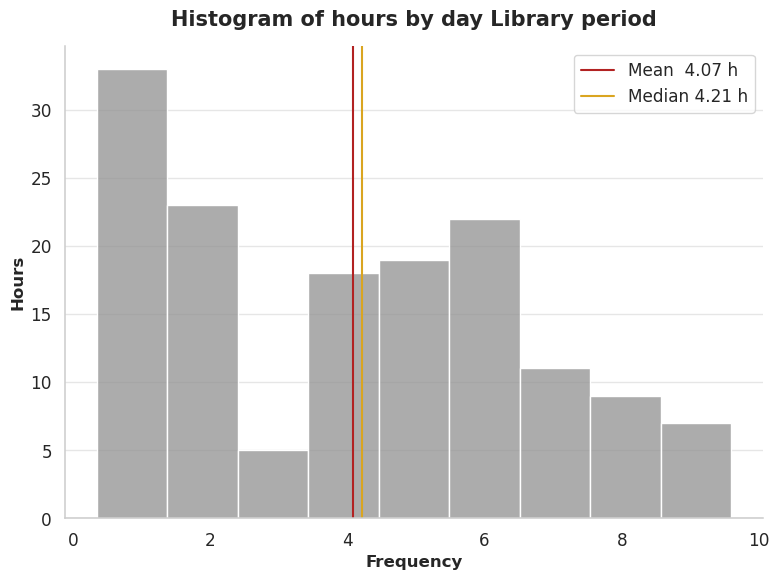

In [64]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.histplot(
    data = study_month_2,
    x = "total_hours",
    bins = "auto",
    kde = False,
    color = "#919191F1"
)

ax.axvline(mean_h2, color="firebrick", ls='-', lw=1.5, label=f"Mean  {mean_h2:.2f} h")
ax.axvline(median_h2, color="goldenrod", ls="-", lw=1.5, label=f"Median {median_h2:.2f} h")

ax.legend()
ax.set_xlabel("Frequency", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Histogram of hours by day Library period", fontsize=15, weight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/histogram_hours_per_day_p2.png", dpi=300, bbox_inches="tight")
plt.show()

Save the data in parquet file for further statistical analysis

In [65]:
p2_path: str = "../data/p2.parquet"
study_month_2.to_parquet(p2_path)
logging.info(f"Saved data in {p2_path}")

2025-11-21 17:24:09,840 - INFO - Saved data in ../data/p2.parquet
